In [9]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm

from scipy.optimize import curve_fit


from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder

from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, hstack, vstack
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.table import Table
from astropy.io import fits
from astropy.stats import sigma_clipped_stats

In [10]:
I_hdu = fits.open(get_pkg_data_filename(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85/Abell_85_aFix_pol_I_Farcsec_fcube_cor.fits'))[0]
I_cube = I_hdu.data[0]
Q_hdu = fits.open(get_pkg_data_filename(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85/Abell_85_aFix_pol_Q_Farcsec_fcube_cor.fits'))[0]
Q_cube = Q_hdu.data[0]
U_hdu = fits.open(get_pkg_data_filename(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85/Abell_85_aFix_pol_U_Farcsec_fcube_cor.fits'))[0]
U_cube = U_hdu.data[0]
V_hdu = fits.open(get_pkg_data_filename(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85/Abell_85_aFix_pol_V_Farcsec_fcube_cor.fits'))[0]
V_cube = V_hdu.data[0]

I_freqmean = np.nanmean(I_cube, axis=0)
Q_freqmean = np.nanmean(Q_cube, axis=0)
U_freqmean = np.nanmean(U_cube, axis=0)
V_freqmean = np.nanmean(V_cube, axis=0)


I_wcs = WCS(I_hdu.header)
Q_wcs = WCS(Q_hdu.header)
U_wcs = WCS(U_hdu.header)
V_wcs = WCS(V_hdu.header)

In [13]:
linpol_intens_cube = np.sqrt(Q_cube**2+U_cube**2)
linpol_intens_freqmean = np.nanmean(linpol_intens_cube, axis=0)

Linpol_hdu = fits.PrimaryHDU(linpol_intens_cube)
Linpol_hdu.writeto('Abell_85_Linpol_Farcsec_fcube_cor.fits', overwrite=True)

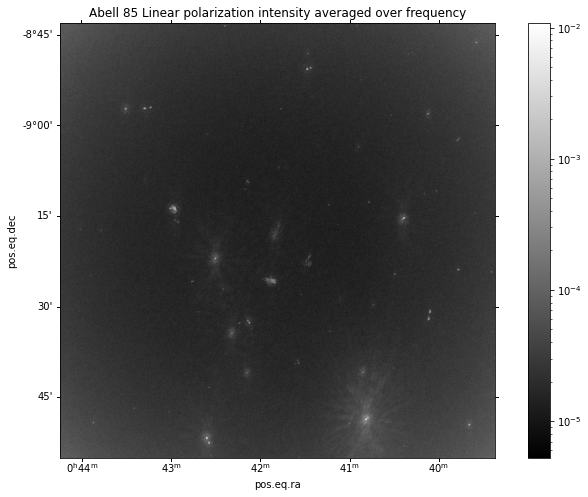

In [14]:
plt.figure(figsize=(12,8))
plt.subplot(projection=I_wcs, slices=('x', 'y', 0, 0))
plt.title('Abell 85 Linear polarization intensity averaged over frequency')
plt.imshow(linpol_intens_freqmean.clip(min=0.0000001), cmap='gray', norm=colors.LogNorm())
plt.colorbar()
plt.savefig('ACO85_Linpol_Freqmean.pdf', dpi=500)

In [45]:
backgr_mean, backgr_median, backgr_std = sigma_clipped_stats(linpol_intens_freqmean, sigma=3.0)
print((backgr_mean, backgr_median, backgr_std))

(2.2228118e-05, 2.056794e-05, 7.4738346e-06)


In [46]:
daofind = DAOStarFinder(fwhm=3.0, threshold=np.sqrt(12)*3*backgr_std)
sources = daofind(linpol_intens_freqmean - backgr_median)
for col in sources.colnames:
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)

 id xcentroid ycentroid sharpness  ... sky      peak        flux       mag     
--- --------- --------- ---------- ... --- ------------- --------- ------------
  1 1240.3743 125.05221 0.40063999 ...   0  0.0031750763 12.902322   -2.7766697
  2 1219.7997  167.3948 0.39890794 ...   0  0.0059659723 19.834065   -3.2435293
  3 3402.9638  276.6438 0.39958119 ...   0  0.0025882686 9.3137564   -2.4228122
  4  276.9332 292.87753 0.39891927 ...   0 0.00044727101 1.6578485  -0.54886213
  5 2536.2357 303.70036 0.40582735 ...   0  0.0004094062 1.0213854 -0.022974133
  6 2550.9457 307.30776 0.39009826 ...   0 0.00038503329 1.0856967 -0.089271269
  7 2540.8233 309.27523 0.40376552 ...   0  0.0005052943 1.3174664  -0.29934885
  8 2530.1416 311.28941 0.40689776 ...   0 0.00039638649 1.3044421  -0.28856199
  9 2544.4722   321.465 0.39895931 ...   0   0.010829131 38.245097   -3.9564394
 10 2532.3276  323.0863 0.40942622 ...   0 0.00038384809 1.3148333  -0.29717675
...       ...       ...        ... ... .

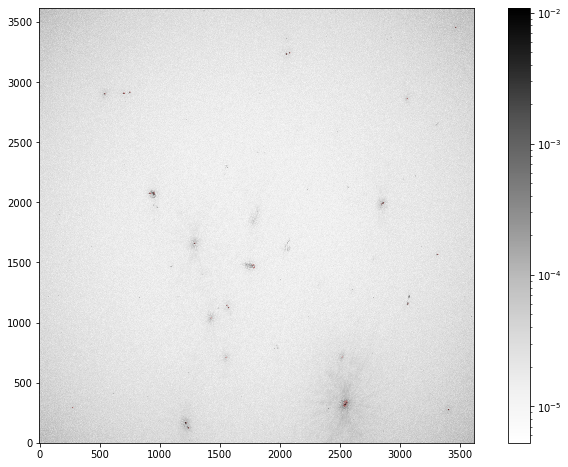

In [47]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(12,8))
plt.imshow(linpol_intens_freqmean.clip(min=0.0000001), cmap='Greys', origin='lower', norm=colors.LogNorm(), interpolation='nearest')
plt.colorbar()
apertures.plot(color='red', lw=0.1)
plt.savefig('ACO85_Linpol_FreqmeanSourcedetect.pdf', dpi=500)